In [1]:
import sys
sys.path.append('../Codes/library')
import numpy as np
import math
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from Immuno_models import*
from io import StringIO
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
import scipy.special as sc
import os.path
import pickle
from matplotlib import style
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import expon, gamma, erlang
from IPython.display import display, Math
import json

Text_files_path = '/Users/robertomorantovar/Dropbox/Research/Evolution_Immune_System/Text_files/'

N_A = 6.02214076e23
k_BT = 1.380649e-23*293
style.use('seaborn-paper')
print(style.available)
%autosave 60

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Autosaving every 60 seconds


In [2]:
def my_gamma(t, g, rho, tau):
    return (1-sp.special.gammainc(g, (rho-(1/tau))*t))*(sp.special.gamma(g))
def my_function(t, g, rho, tau):
    return (t**g)*((rho-(1/tau))*t)**(-g)*my_gamma(t, g, rho, tau)
def my_distribution(t, g, rho, tau):
    return ((rho**g*np.exp(-(1/tau)*t))/(math.factorial(g-1)*tau))*(-my_function(t, g, rho, tau) + my_function(0.01, g, rho, tau))
def my_function2(t, g, rho, tau, eta):
    dt = t[1]-t[0]
    constant1 = ((rho**g*np.exp(-(1/tau)*t[1:]))/(math.factorial(g-1)*math.factorial(eta-1)*tau**(eta)))
    
    return constant1*np.array([np.sum(t[:i]**(g-1)*(t[i]-t[:i])**(eta-1)*np.exp(-(rho-(1/tau))*t[:i])*dt) for i in np.arange(1, len(t))])

def my_function3(t, g, rho, tau, eta):
    dt = t[1]-t[0]
    constant1 = ((rho**g*np.exp(-rho*t[1:]))/(math.factorial(g-1)*math.factorial(eta-1)*tau**(eta)))
    return constant1*np.array([np.sum(t[:i]**(eta-1)*(t[i]-t[:i])**(g-1)*np.exp(-((1/tau)-rho)*t[:i])*dt) for i in np.arange(1, len(t))])


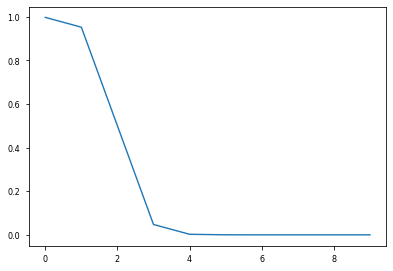

In [503]:
x = np.arange(0, 10)
plt.plot(x, binding_affinity(x, -6, 3.0))

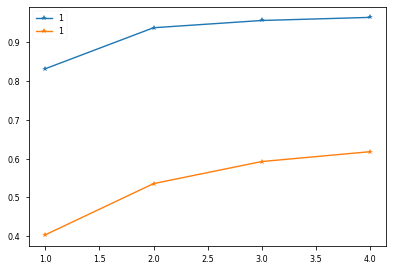

In [4]:
a = -2
b = 1
N_epitopes = np.arange(1, 5, 1)
rhos = np.logspace(-1, np.log10(3), 2)
tau = 1
T = 1000
for rho in rhos:
    R_bar = np.array([])
    for g in N_epitopes:
        n_mutations = np.zeros(g) #Array with number of mutatios in each epitope
        neutralizations = binding_affinity(n_mutations, a, b) #Array with individuals neutralization probabilities
        time = np.array([0]) #Array with time
        t = time[-1]
        time_intervals = np.array([])
        exposure_times = np.array([0])
        sick_times = np.array([])
        R = np.array([1-np.min(1-neutralizations)]) #Array with total recognition function
        propensities = np.array(np.concatenate(([rho]*g, [1/tau]))) #Array with propensities
        i = 0
        while (t<T):
            i+=1
            cumsum = np.cumsum(propensities)
            alpha = np.sum(propensities)
            r1 = np.random.rand()
            dti = (1/alpha)*np.log(float(1/r1))
            time_intervals = np.append(time_intervals, dti)
            t = t+dti
            time = np.append(time, t)
            r2 = np.random.rand()
            idEvent = np.searchsorted(cumsum,r2*alpha)
            if(idEvent<g):#mutation
                n_mutations[idEvent]+=1
            else:#exposure
                exposure_times = np.append(exposure_times, t)
                r_sick = np.random.rand()
                if(r_sick>R[-1]): #sick
                    n_mutations = np.zeros(g) #update mutations
                    sick_times = np.append(sick_times, t)
            neutralizations = binding_affinity(n_mutations, a, b) #update neutralizations  
            R = np.append(R, 1-np.product(1-neutralizations)) #update R

        #R_bar = np.append(R_bar, np.sum(R[:-1]*time_intervals)/time[-1])
        R_bar = np.append(R_bar, 1-np.size(sick_times)/np.size(exposure_times))
        
    plt.plot(N_epitopes, R_bar, linestyle = '-', marker = '*', label = tau)
plt.legend(loc = 0)


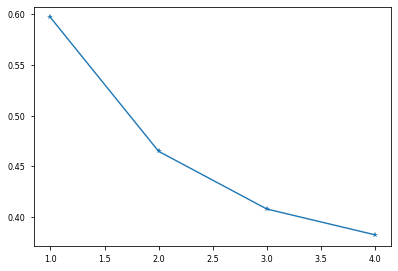

In [5]:
plt.plot(N_epitopes, 1-R_bar, linestyle = '-', marker = '*')

(0.0, 20.0)

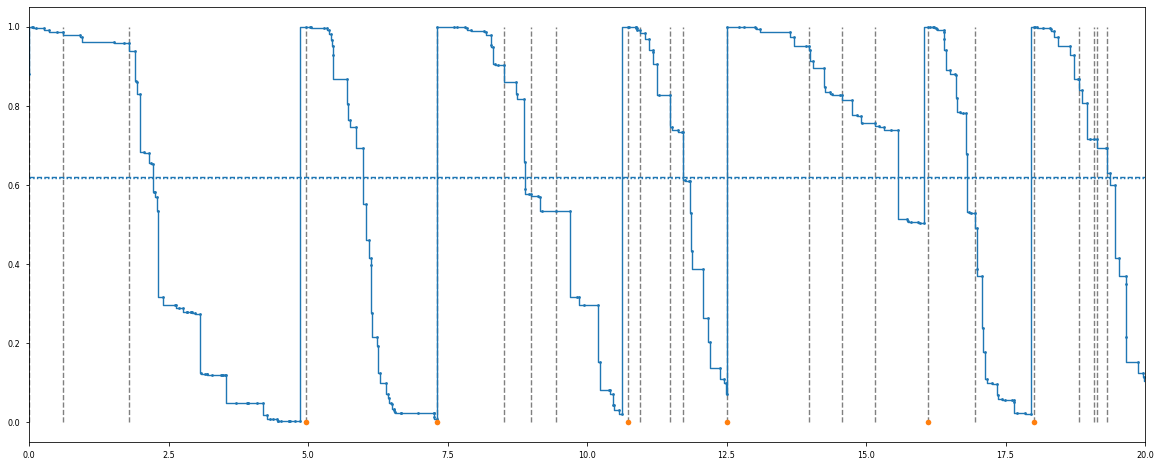

In [6]:
fig, ax = plt.subplots(figsize = (20,8))
ax.step(time, R, '.-')
ax.plot(sick_times, np.zeros_like(sick_times), 'o')
ax.vlines(exposure_times, 0, 1, linestyle = '--', color = 'grey')
ax.hlines(np.sum(R[:-1]*time_intervals)/np.sum(time_intervals), 0, T, linestyle = '--')
ax.hlines(1-np.size(sick_times)/np.size(exposure_times), 0, T, linestyle = 'dotted')
ax.set_xlim(0, 20)
#ax.hlines(np.mean(R), 0, T, linestyle = 'dotted')

0.9839474076926066
2.443024913675592 2.4437500653646698


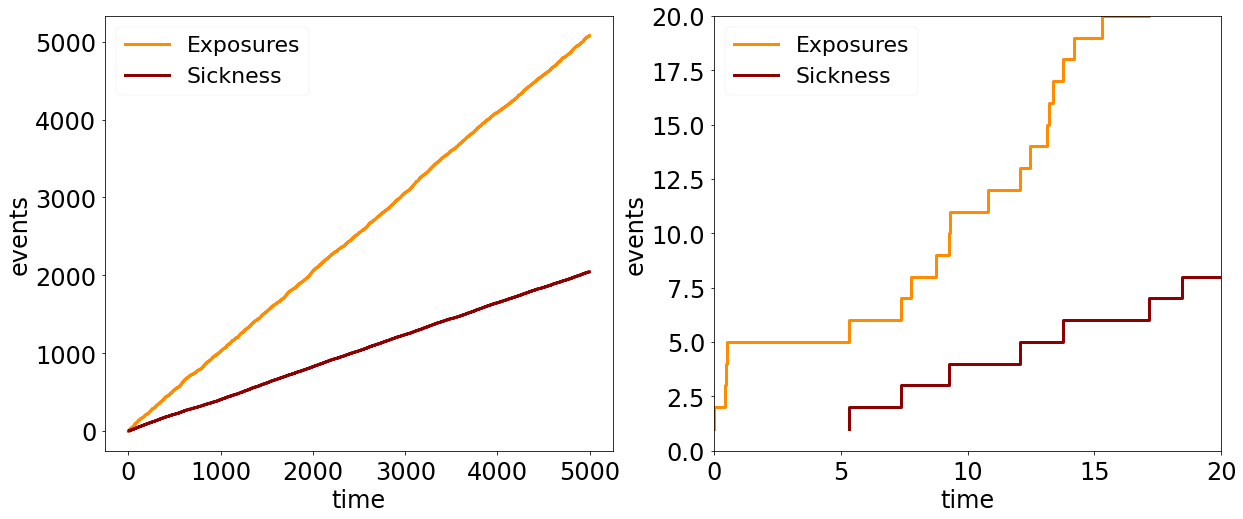

In [545]:
fig, ax = plt.subplots(1,2,figsize = (20,8))
ax[0].step(exposure_times, np.arange(1, np.size(exposure_times)+1, 1), label = 'Exposures', color = "darkorange", linewidth = 3)
ax[0].step(sick_times, np.arange(1, np.size(sick_times)+1, 1), label = 'Sickness', color = 'darkred', linewidth = 3)
ax[0].legend(fontsize = 22)
my_plot_layout(ax=ax[0], xlabel = 'time', ylabel = 'events')

ax[1].step(exposure_times, np.arange(1, np.size(exposure_times)+1, 1), label = 'Exposures', color = "darkorange", linewidth = 3)
ax[1].step(sick_times, np.arange(1, np.size(sick_times)+1, 1), label = 'Sickness', color = 'darkred', linewidth = 3)
ax[1].legend(fontsize = 22)
my_plot_layout(ax=ax[1], xlabel = 'time', ylabel = 'events')
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 20)
tau_e_bar = 1/(np.size(exposure_times)/exposure_times[-1])
tau_i_bar = 1/(np.size(sick_times)/sick_times[-1])
print(tau_e_bar)
print(tau_i_bar, tau_e_bar/(1-R_bar[-1]))

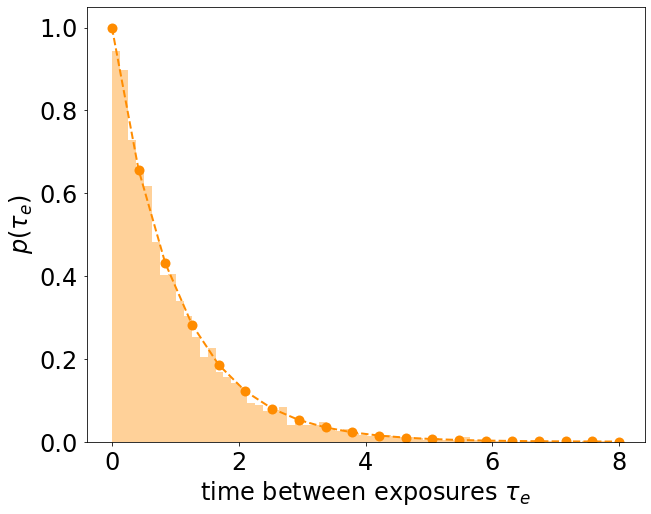

In [562]:
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(exposure_times[2:]-exposure_times[1:-1], bins = 'auto', density = True, alpha=.4, color = "darkorange")
t = np.linspace(0, 8*tau, 20)
ax.plot(t, expon.pdf(t, scale = 1), linewidth = 2, ms = 10, linestyle = '--', marker = 'o', color = "darkorange")
my_plot_layout(ax=ax, xlabel = r'time between exposures $\tau_e$', ylabel = r'$p(\tau_e)$')
#plt.yscale('log')

2.3333331580423913 2.4437500653646698 2.443024913675592
4 3.0 1 2


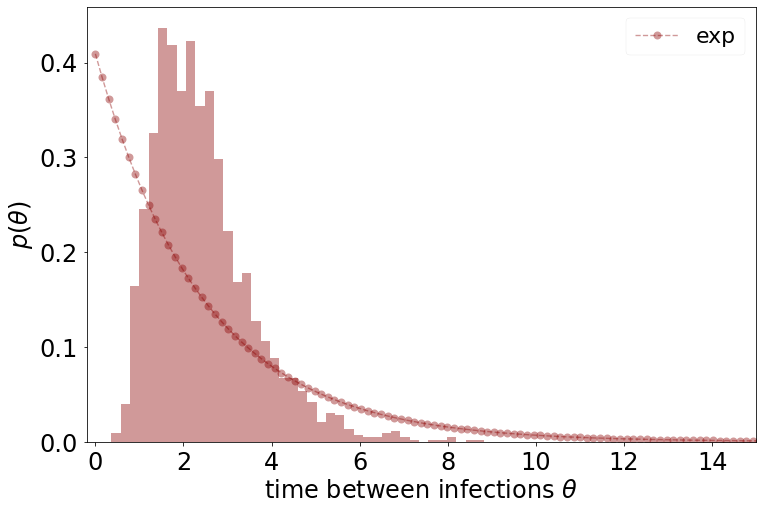

In [547]:
fig, ax = plt.subplots(figsize = (12,8))
ax.hist(sick_times[2:]-sick_times[1:-1], bins ='auto', density = True, alpha=.4, color = 'darkred')
t = np.linspace(0.001, 30, 200)
dt = t[1]-t[0]
ax.plot(t, expon.pdf(t, scale = tau_i_bar), label = 'exp', linestyle = '--',ms = 8, marker = 'o', alpha = .4, color = 'darkred')
#ax.plot(t, gamma.pdf(t, a = tau_e_bar*((g/rho)+tau_e_bar)/((1-R_bar[-1])), scale = 1/((g/rho)+tau_e_bar)), linestyle = '--', marker = 'o', label = 'gamma')
#ax.plot(t, np.sqrt(expon.pdf(t, scale = tau_e_bar)*erlang.pdf(t, a = int(g), scale = 1/rho)), label = 'erlang', linestyle = '--', marker = 'o')
#ax.plot(t, my_distribution(t, int(g), rho, tau), label = 'my distribution', linestyle = '--',ms = 8, marker = 's', color = 'darkred')
eta = int(1/(1-R_bar[-1]))
#ax.plot(t[1:], my_function2(t, g, rho, tau, eta), linestyle = '--', marker = 'o')
#ax.plot(t[1:], my_function3(t, int(g), rho, tau, eta), linestyle = '--',ms = 8, marker = '^', label = 'man convolution', color = 'darkred')
#ax.plot(np.linspace(0.001, 20, 2*1000-1), np.convolve(dt*gamma.pdf(t, a=g, scale = 1/rho), gamma.pdf(t, a=1, scale = tau)), linestyle = '--', marker = 'o', label = 'convolution')
print(np.cumsum(t*my_distribution(t, int(g), rho, tau)*dt)[-1], tau_e_bar/(1-R_bar[-1]), tau_i_bar)
my_plot_layout(ax=ax, xlabel = r'time between infections $\theta$', ylabel = r'$p(\theta)$')
ax.set_xlim(-0.2, 15)
print(g, rho, tau, eta)
ax.legend(fontsize = 22)
#ax.set_yscale('log')


2.3333331580423913 2.4437500653646698 2.443024913675592
4 3.0 1 2


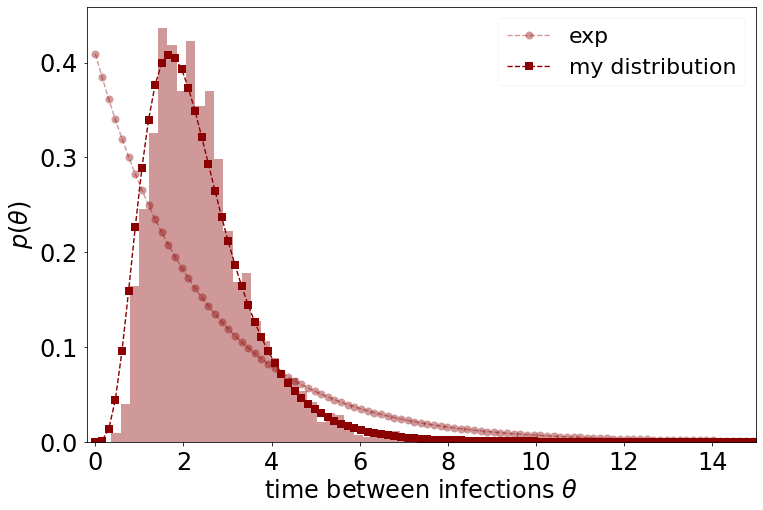

In [548]:
fig, ax = plt.subplots(figsize = (12,8))
ax.hist(sick_times[2:]-sick_times[1:-1], bins ='auto', density = True, alpha=.4, color = 'darkred')
t = np.linspace(0.001, 30, 200)
dt = t[1]-t[0]
ax.plot(t, expon.pdf(t, scale = tau_i_bar), label = 'exp', linestyle = '--',ms = 8, marker = 'o', alpha = .4, color = 'darkred')
#ax.plot(t, gamma.pdf(t, a = tau_e_bar*((g/rho)+tau_e_bar)/((1-R_bar[-1])), scale = 1/((g/rho)+tau_e_bar)), linestyle = '--', marker = 'o', label = 'gamma')
#ax.plot(t, np.sqrt(expon.pdf(t, scale = tau_e_bar)*erlang.pdf(t, a = int(g), scale = 1/rho)), label = 'erlang', linestyle = '--', marker = 'o')
ax.plot(t, my_distribution(t, int(g), rho, tau), label = 'my distribution', linestyle = '--',ms = 8, marker = 's', color = 'darkred')
eta = int(1/(1-R_bar[-1]))
#ax.plot(t[1:], my_function2(t, g, rho, tau, eta), linestyle = '--', marker = 'o')
#ax.plot(t[1:], my_function3(t, int(g), rho, tau, eta), linestyle = '--',ms = 8, marker = '^', label = 'man convolution', color = 'darkred')
#ax.plot(np.linspace(0.001, 20, 2*1000-1), np.convolve(dt*gamma.pdf(t, a=g, scale = 1/rho), gamma.pdf(t, a=1, scale = tau)), linestyle = '--', marker = 'o', label = 'convolution')
print(np.cumsum(t*my_distribution(t, int(g), rho, tau)*dt)[-1], tau_e_bar/(1-R_bar[-1]), tau_i_bar)
my_plot_layout(ax=ax, xlabel = r'time between infections $\theta$', ylabel = r'$p(\theta)$')
ax.set_xlim(-0.2, 15)
print(g, rho, tau, eta)
ax.legend(fontsize = 22)
#ax.set_yscale('log')



2.3333331580423913 2.4437500653646698 2.443024913675592
4 3.0 1 2


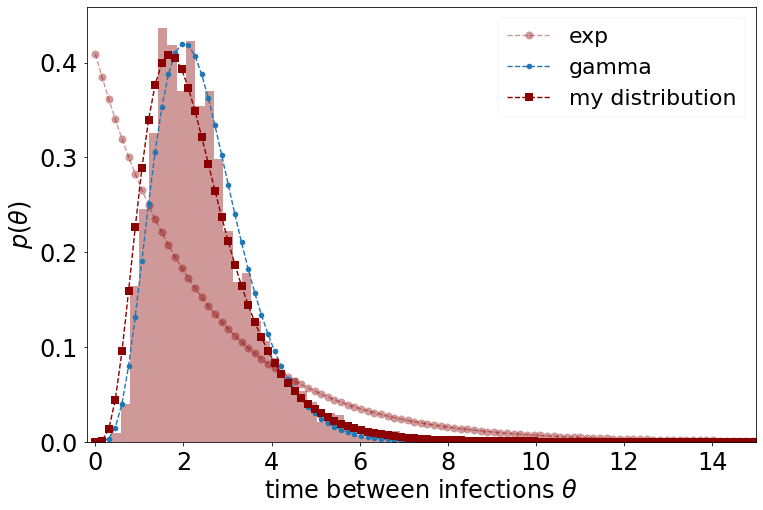

In [561]:
fig, ax = plt.subplots(figsize = (12,8))
ax.hist(sick_times[2:]-sick_times[1:-1], bins ='auto', density = True, alpha=.4, color = 'darkred')
t = np.linspace(0.001, 30, 200)
dt = t[1]-t[0]
ax.plot(t, expon.pdf(t, scale = tau_i_bar), label = 'exp', linestyle = '--',ms = 8, marker = 'o', alpha = .4, color = 'darkred')
#ax.plot(t, expon.pdf(t, scale = tau_e_bar), label = 'exp', linestyle = '--',ms = 8, marker = 'o', alpha = .4, color = 'darkorange')
ax.plot(t, gamma.pdf(t, a = tau_e_bar*((g/rho)+tau_e_bar)/((1-R_bar[-1])), scale = 1/((g/rho)+tau_e_bar)), linestyle = '--', marker = 'o', label = 'gamma')
#ax.plot(t, np.sqrt(expon.pdf(t, scale = tau_e_bar)*erlang.pdf(t, a = int(g), scale = 1/rho)), label = 'erlang', linestyle = '--', marker = 'o')
ax.plot(t, my_distribution(t, int(g), rho, tau), label = 'my distribution', linestyle = '--',ms = 8, marker = 's', color = 'darkred')
eta = int(1/(1-R_bar[-1]))
#ax.plot(t[1:], my_function2(t, g, rho, tau, 1), linestyle = '--', marker = 'o')
#ax.plot(t[1:], my_function3(t, int(g), rho, tau, eta), linestyle = '--',ms = 8, marker = '^', label = 'man convolution', color = 'darkred')
#ax.plot(np.linspace(0.001, 20, 2*200-1), np.convolve(dt*gamma.pdf(t, a=g, scale = 1/rho), gamma.pdf(t, a=1, scale = tau)), linestyle = '--', marker = 'o', label = 'convolution')
print(np.cumsum(t*my_distribution(t, int(g), rho, tau)*dt)[-1], tau_e_bar/(1-R_bar[-1]), tau_i_bar)
my_plot_layout(ax=ax, xlabel = r'time between infections $\theta$', ylabel = r'$p(\theta)$')
ax.set_xlim(-0.2, 15)
print(g, rho, tau, eta)
ax.legend(fontsize = 22)
#ax.set_yscale('log')


